# Predicting 1-Year and 5-Year Cancer Survival Using Regression Models

**Author:** Vinod Kasturi  
**Course:** Berkeley Professional Certificate in Machine Learning & AI  

In this notebook, we use the **Get Data Out (GDO) Cancer Groups Dataset** (UK NDRS) to build 
regression models that predict:

- **1-year net survival** (`Net survival 12m`)
- **5-year net survival** (`Net survival 60m`)

based on cancer site, tumour type, stage, region, and treatment patterns.

---



## 1. Setup and Data Loading

In [43]:
# 1. Imports & configuration

import numpy as np
import pandas as pd

#!pip install seaborn

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [44]:
# Display options
pd.set_option("display.max_columns", 100)
sns.set(style="whitegrid")

In [45]:
# Set the seed for random state
RANDOM_STATE = 42

In [46]:
def regression_metrics(y_true, y_pred, model_name="Model"):
    """
    Compute and print R², RMSE, and MAE for a regression model.
    """
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    print(f"{model_name} Performance:")
    print(f"  R²   : {r2:.3f}")
    print(f"  RMSE : {rmse:.3f}")
    print(f"  MAE  : {mae:.3f}\n")
    return {"model": model_name, "r2": r2, "rmse": rmse, "mae": mae}

- **Load data from CSV File**

In [47]:
# 2. Load and inspect data

data_path = "Data/GDO_data_wide.csv"  # update if needed
df = pd.read_csv(data_path, low_memory=False)

print("Shape:", df.shape)
df.head()


Shape: (56610, 230)


,Cancer Site,Year,Tumour Type,Tumour Type 2,Tumour Type 3,Tumour Type 4,Tumour Type 5,Tumour Type 6,Tumour Type 7,Basis of Diagnosis,Stage,Stage Detail,Stage Detail 2,Stage Detail 3,Age,Age Detail,Region,Gender,Grade,Nodal Status,Deprivation,Performance Status,Incidence,Population,Incidence Rate,Incidence Rate LCI,Incidence Rate UCI,Age Gender Standardised Incidence Rate,Age Gender Standardised Incidence Rate LCI,Age Gender Standardised Incidence Rate UCI,Age 00-04 male,Age 05-09 male,Age 10-14 male,Age 15-19 male,Age 20-24 male,Age 25-29 male,Age 30-34 male,Age 35-39 male,Age 40-44 male,Age 45-49 male,Age 50-54 male,Age 55-59 male,Age 60-64 male,Age 65-69 male,Age 70-74 male,Age 75-79 male,Age 80-84 male,Age 85-89 male,Age 90+ male,Age 00-04 female,...,Kaplan-Meier survival 09m LCI,Kaplan-Meier survival 09m UCI,Net survival 12m,Net survival 12m LCI,Net survival 12m UCI,Kaplan-Meier survival 12m,Kaplan-Meier survival 12m LCI,Kaplan-Meier survival 12m UCI,Net survival 24m,Net survival 24m LCI,Net survival 24m UCI,Kaplan-Meier survival 24m,Kaplan-Meier survival 24m LCI,Kaplan-Meier survival 24m UCI,Net survival 36m,Net survival 36m LCI,Net survival 36m UCI,Kaplan-Meier survival 36m,Kaplan-Meier survival 36m LCI,Kaplan-Meier survival 36m UCI,Net survival 48m,Net survival 48m LCI,Net survival 48m UCI,Kaplan-Meier survival 48m,Kaplan-Meier survival 48m LCI,Kaplan-Meier survival 48m UCI,Net survival 60m,Net survival 60m LCI,Net survival 60m UCI,Kaplan-Meier survival 60m,Kaplan-Meier survival 60m LCI,Kaplan-Meier survival 60m UCI,Net survival 72m,Net survival 72m LCI,Net survival 72m UCI,Kaplan-Meier survival 72m,Kaplan-Meier survival 72m LCI,Kaplan-Meier survival 72m UCI,Net survival 84m,Net survival 84m LCI,Net survival 84m UCI,Kaplan-Meier survival 84m,Kaplan-Meier survival 84m LCI,Kaplan-Meier survival 84m UCI,Net survival 96m,Net survival 96m LCI,Net survival 96m UCI,Kaplan-Meier survival 96m,Kaplan-Meier survival 96m LCI,Kaplan-Meier survival 96m UCI
0,"Bladder, urethra, renal pelvis and ureter",2013,All,All,All,All,All,All,All,All,All,All,All,All,All,All,All England,Persons,All,All,All,All,20802,53918686,38.58,38.058,39.108,46.406,45.766,47.052,3,0,2,3,15,17,47,55,130,295,494,830,1376,2203,2574,2813,2308,1444,613,1,...,84.2,85.2,84.9,84.3,85.5,81.6,81.1,82.2,78.8,78.1,79.5,72.9,72.2,73.5,75.7,74.9,76.5,67.1,66.4,67.8,73.6,72.7,74.5,62.5,61.7,63.2,72.1,71.1,73.1,58.5,57.7,59.2,70.9,69.8,72.1,54.6,53.9,55.3,69.3,67.9,70.6,50.7,50,51.4,67.4,65.8,68.9,47,46.3,47.8
1,"Bladder, urethra, renal pelvis and ureter",2013,Renal pelvis and ureter,All,All,All,All,All,All,All,All,All,All,All,All,All,All England,Persons,All,All,All,All,2114,53918686,3.921,3.755,4.091,4.607,4.41,4.811,0,0,0,0,0,0,2,4,6,26,40,74,136,201,243,258,197,120,32,1,...,76.1,80.5,76.8,74.3,79.3,74,71.5,76.2,65.2,62.3,68.1,60.7,58,63.3,61.2,58.2,64.3,54.8,52.1,57.4,56.9,53.6,60.3,49.1,46.3,51.7,54.4,50.8,58,45,42.3,47.6,53.1,49.3,56.9,41.6,39,44.2,51.7,47.6,55.9,38.1,35.5,40.8,52.8,48.3,57.4,35.7,33.2,38.3
2,"Bladder, urethra, renal pelvis and ureter",2013,Renal pelvis and ureter,Malignant and in situ,All,All,All,All,All,All,All,All,All,All,All,All,All England,Persons,All,All,All,All,2087,53918686,3.871,3.706,4.04,4.549,4.353,4.751,0,0,0,0,0,0,2,4,6,26,40,73,136,199,240,253,195,118,32,1,...,75,79.7,75.6,73,78.2,72.8,70.2,75.1,63.7,60.6,66.7,59.2,56.4,61.9,59.5,56.3,62.7,53.1,50.3,55.8,55,51.5,58.5,47.3,44.5,50,52.6,48.8,56.3,43.3,40.6,46.1,50.8,46.9,54.7,39.7,37,42.4,49.7,45.4,54,36.5,33.9,39.2,50.8,46.1,55.6,34.3,31.6,36.9
3,"Bladder, urethra, renal pelvis and ureter",2013,Renal pelvis and ureter,Malignant and in situ,All,All,All,All,All,All,Non-muscle-invasive,All,All,All,All,All,All England,Persons,All,All,All,All,954,53918686,1.769,1.659,1.885,2.082,1.951,2.22,0,0,0,0,0,0,0,3,2,12,14,35,73,104,114,131,88,47,5,0,...,89.1,94,92.6,89.8,95.4,89.7,86.6,92.1,87.8,84.2,91.5,82.4,78.7,85.5,85.7,81.5,89.9,77.3,73.4,80.8,82,77.2,86.8,71.1,66.8,74.8,79.4,74,84.8,66,61.6,70,78.9

## 2.1 Basic structure and data dictionary

We start by inspecting column types and creating a high-level data dictionary.


In [48]:
df.info

<bound method DataFrame.info of                                      Cancer Site       Year  \
0      Bladder, urethra, renal pelvis and ureter       2013   
1      Bladder, urethra, renal pelvis and ureter       2013   
2      Bladder, urethra, renal pelvis and ureter       2013   
3      Bladder, urethra, renal pelvis and ureter       2013   
4      Bladder, urethra, renal pelvis and ureter       2013   
...                                          ...        ...   
56605                                     Testes  2020-2022   
56606                                     Testes  2020-2022   
56607                                     Testes  2020-2022   
56608                                     Testes  2020-2022   
56609                                     Testes  2020-2022   

                   Tumour Type          Tumour Type 2 Tumour Type 3  \
0                          All                    All           All   
1      Renal pelvis and ureter                    All           All  

In [49]:
# Quick peek at some key columns
cols_of_interest = [
    "Cancer Site", "Year", "Tumour Type", "Stage", "Age", "Region", "Gender",
    "Incidence", "Incidence Rate",
    "Initial cohort size", "Survival cohort size",
    "CT percentage", "RT percentage", "Surgery percentage",
    "Other care percentage",
    "Net survival 12m", "Net survival 60m"
]

#[df[c].head(5) for c in cols_of_interest if c in df.columns]


## 3. Data Cleaning: Types, Missing Values, and Duplicates


In [50]:
# Columns that should stay as categorical "descriptors"
descriptor_cols = [
    "Cancer Site", "Tumour Type", "Tumour Type 2", "Tumour Type 3",
    "Tumour Type 4", "Tumour Type 5", "Tumour Type 6", "Tumour Type 7",
    "Basis of Diagnosis", "Stage", "Stage Detail", "Stage Detail 2",
    "Stage Detail 3", "Age", "Age Detail", "Region", "Gender",
    "Grade", "Nodal Status"
]

# Convert all non-descriptor columns to numeric where possible
for col in df.columns:
    if col not in descriptor_cols:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Remove duplicate rows, if any
print("Duplicates before:", df.duplicated().sum())
df = df.drop_duplicates()
print("Duplicates after:", df.duplicated().sum())

# Check missing values (fraction of NA) for numeric columns
numeric_cols = df.select_dtypes(include=["number"]).columns
missing_fraction = df[numeric_cols].isna().mean().sort_values(ascending=False)
missing_fraction.head(20)


Duplicates before: 130
Duplicates after: 0


Performance Status               1.000000
Screening percentage UCI         0.990581
Screening                        0.990581
Screening percentage             0.990581
Screening percentage LCI         0.990581
Net survival 96m UCI             0.975726
Net survival 96m                 0.975726
Net survival 96m LCI             0.975726
Deprivation                      0.974186
Kaplan-Meier survival 96m        0.953807
Kaplan-Meier survival 96m LCI    0.953807
Kaplan-Meier survival 96m UCI    0.953807
Net survival 84m UCI             0.942635
Net survival 84m LCI             0.942635
Net survival 84m                 0.942635
Kaplan-Meier survival 84m UCI    0.907596
Kaplan-Meier survival 84m LCI    0.907596
Kaplan-Meier survival 84m        0.907596
Net survival 72m UCI             0.872928
Net survival 72m LCI             0.872928
dtype: float64

## 3.1 Define a modeling subset

To reduce noise and focus on interpretable patterns, we restrict to:
- **Region = All England**
- **Gender = Persons**
- **Age = All**

This yields aggregated cohorts by cancer site, tumour type, and stage for the full population.


In [51]:
df_model = (
    df
    .query("Region == 'All England' and Gender == 'Persons' and Age == 'All'")
    .copy()
)

print("Modeling subset shape:", df_model.shape)
df_model[["Cancer Site", "Tumour Type", "Stage"]].head()


Modeling subset shape: (9146, 230)


,Cancer Site,Tumour Type,Stage
0,"Bladder, urethra, renal pelvis and ureter",All,All
1,"Bladder, urethra, renal pelvis and ureter",Renal pelvis and ureter,All
2,"Bladder, urethra, renal pelvis and ureter",Renal pelvis and ureter,All
3,"Bladder, urethra, renal pelvis and ureter",Renal pelvis and ureter,Non-muscle-invasive
4,"Bladder, urethra, renal pelvis and ureter",Renal pelvis and ureter,Non-muscle-invasive


## 3.2 Targets and candidate features

We model:

- **y₁:** `Net survival 12m` (1-year net survival)
- **y₅:** `Net survival 60m` (5-year net survival)

Predictors include:
- Cancer site, tumour type, stage (categorical)
- Year, incidence rate, cohort sizes
- Treatment percentages (CT, RT, Surgery, combinations, other care)


In [52]:
target_cols = ["Net survival 12m", "Net survival 60m"]

categorical_features = ["Cancer Site", "Tumour Type", "Stage"]

numeric_feature_cols = [
    "Year",
    "Incidence Rate",
    "Age Gender Standardised Incidence Rate",
    "Initial cohort size",
    "Survival cohort size",
    "CT percentage", "RT percentage", "Surgery percentage",
    "CT only percentage", "RT only percentage", "Surgery only percentage",
    "CT and RT percentage", "Surgery and CT percentage",
    "Surgery and RT percentage", "Surgery and CT and RT percentage",
    "Other care percentage",
]

# Drop rows with missing targets or key numeric features
df_model_clean = df_model.dropna(subset=target_cols + numeric_feature_cols)

print("After dropping NAs:", df_model_clean.shape)
df_model_clean[target_cols].describe()

After dropping NAs: (1026, 230)


,Net survival 12m,Net survival 60m
count,1026.000000,1026.000000
mean,69.554581,48.350780
std,24.165745,30.207653
min,6.100000,0.800000
25%,47.625000,18.925000
50%,75.100000,49.150000
75%,91.100000,76.775000
max,101.900000,112.200000


## 4. Exploratory Data Analysis (EDA)

### 4.1 Distribution of 1-year and 5-year survival rates


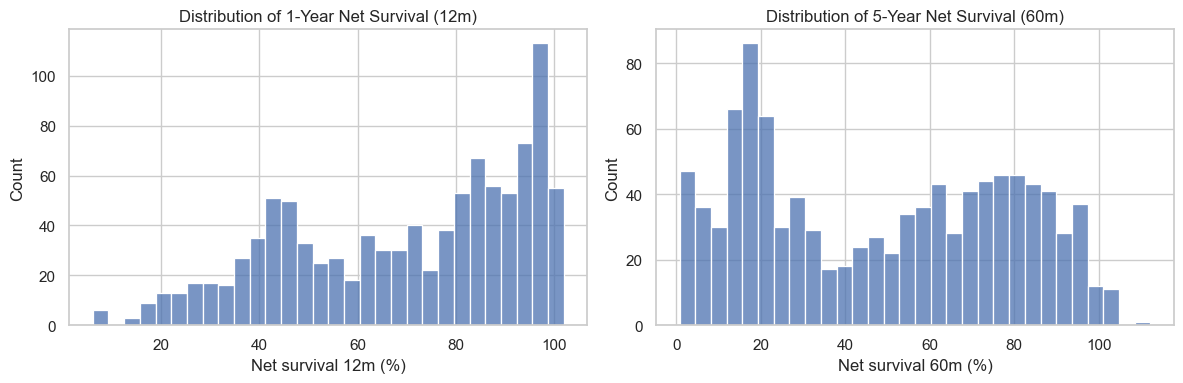

In [53]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(df_model_clean["Net survival 12m"], bins=30, ax=axes[0])
axes[0].set_title("Distribution of 1-Year Net Survival (12m)")
axes[0].set_xlabel("Net survival 12m (%)")
axes[0].set_ylabel("Count")

sns.histplot(df_model_clean["Net survival 60m"], bins=30, ax=axes[1])
axes[1].set_title("Distribution of 5-Year Net Survival (60m)")
axes[1].set_xlabel("Net survival 60m (%)")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()


### 4.2 Survival by Stage
We examine how survival varies across clinical stage.


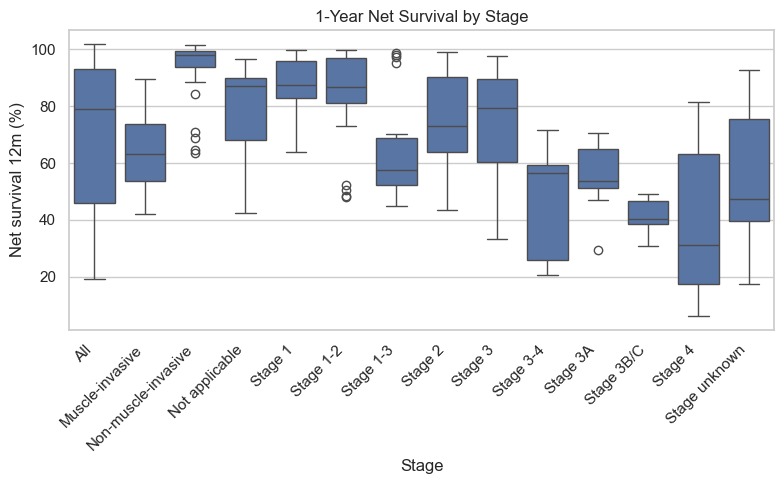

In [54]:
plt.figure(figsize=(8, 5))
sns.boxplot(
    data=df_model_clean,
    x="Stage",
    y="Net survival 12m",
    order=sorted(df_model_clean["Stage"].dropna().unique())
)
plt.title("1-Year Net Survival by Stage")
plt.xlabel("Stage")
plt.ylabel("Net survival 12m (%)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


### 4.3 Relationship between Incidence Rate and 1-Year Survival


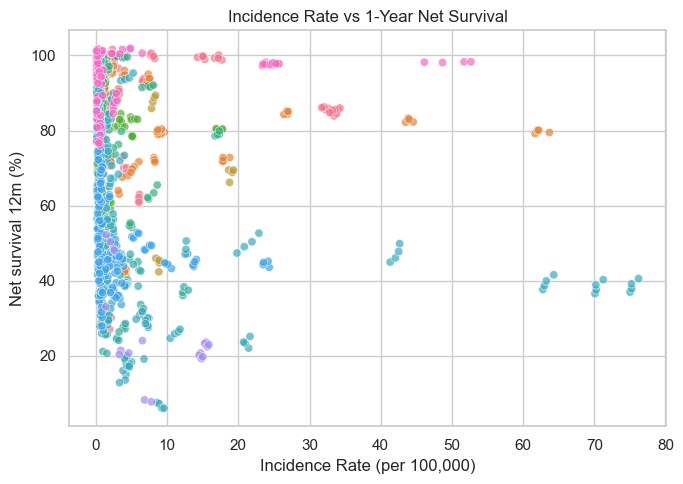

In [55]:
plt.figure(figsize=(7, 5))
sns.scatterplot(
    data=df_model_clean,
    x="Incidence Rate",
    y="Net survival 12m",
    hue="Cancer Site",
    alpha=0.7,
    legend=False
)
plt.title("Incidence Rate vs 1-Year Net Survival")
plt.xlabel("Incidence Rate (per 100,000)")
plt.ylabel("Net survival 12m (%)")
plt.tight_layout()
plt.show()


### 4.4 Outlier analysis for key numeric features


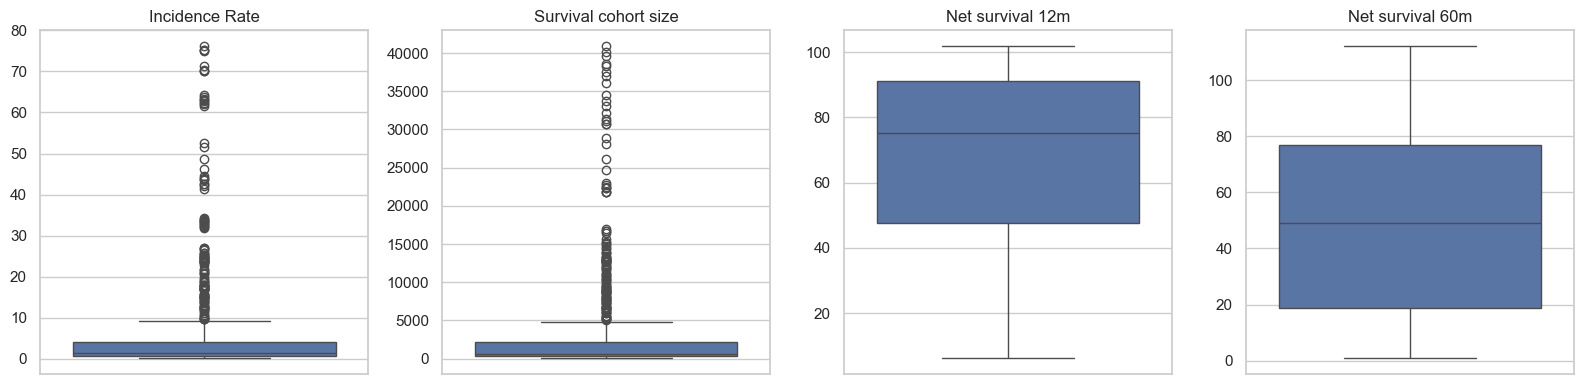

In [56]:
key_numeric = ["Incidence Rate", "Survival cohort size", "Net survival 12m", "Net survival 60m"]

fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for i, col in enumerate(key_numeric):
    sns.boxplot(y=df_model_clean[col], ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_ylabel("")
plt.tight_layout()
plt.show()


## 5. Feature Engineering

Here we:
- Keep the most informative categorical features (Cancer Site, Tumour Type, Stage).
- Use numeric treatment and incidence features as-is.
- Optionally, restrict to cohorts with reasonable survival cohort size to avoid very noisy small groups.


In [57]:
# Filter out very small survival cohorts (e.g., < 30 patients)
min_cohort_size = 30
df_fe = df_model_clean[df_model_clean["Survival cohort size"] >= min_cohort_size].copy()

print("After cohort size filter:", df_fe.shape)

X = df_fe[categorical_features + numeric_feature_cols]
y_12 = df_fe["Net survival 12m"]
y_60 = df_fe["Net survival 60m"]


After cohort size filter: (1026, 230)


## 6. Modeling: Baseline Regression Models

We start with **1-year net survival** as the target (`Net survival 12m`).
We will:
- One-hot encode categorical variables
- Standardize numeric variables
- Compare a baseline **Linear Regression** to a **Random Forest Regressor**
- Evaluate using **R², RMSE, MAE**

Rationale for metrics:
- **R²**: how much variance in survival is explained.
- **RMSE**: penalizes larger errors, good for continuous outcomes.
- **MAE**: interpretable average absolute error in survival percentage points.


In [58]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_12, test_size=0.2, random_state=RANDOM_STATE
)

numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_features),
        ("num", numeric_transformer, numeric_feature_cols),
    ]
)


In [59]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(
        n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1
    ),
}

results = []

for name, model in models.items():
    pipe = Pipeline(steps=[
        ("preprocess", preprocessor),
        ("model", model),
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    results.append(regression_metrics(y_test, y_pred, name))

results_df = pd.DataFrame(results).set_index("model").sort_values("r2", ascending=False)
results_df


Linear Regression Performance:
  R²   : 0.845
  RMSE : 9.625
  MAE  : 6.431

Random Forest Performance:
  R²   : 0.952
  RMSE : 5.376
  MAE  : 3.700



,r2,rmse,mae
model,,,
Random Forest,0.951757,5.376288,3.699840
Linear Regression,0.845364,9.625455,6.430792


### 6.1 Cross-validation for the best model

We select the best-performing model (by R²) and estimate its performance via cross-validation
to obtain a more robust error estimate.


In [60]:
best_model_name = results_df.index[0]
print("Best model based on R²:", best_model_name)

best_model = models[best_model_name]

best_pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", best_model),
])

cv_scores = cross_val_score(
    best_pipe,
    X,
    y_12,
    cv=5,
    scoring="r2",
    n_jobs=-1
)

print(f"Cross-validated R² for {best_model_name}: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")


Best model based on R²: Random Forest
Cross-validated R² for Random Forest: 0.697 ± 0.251


## 7. Modeling: 5-Year Net Survival (60m)

We now reuse the same features and preprocessing pipeline and predict `Net survival 60m`.
We use the same model type that performed best on the 1-year target to keep the comparison simple.


In [61]:
X_train_60, X_test_60, y_train_60, y_test_60 = train_test_split(
    X, y_60, test_size=0.2, random_state=RANDOM_STATE
)

pipe_60 = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", best_model),
])

pipe_60.fit(X_train_60, y_train_60)
y_pred_60 = pipe_60.predict(X_test_60)

metrics_60 = regression_metrics(y_test_60, y_pred_60, f"{best_model_name} (60m)")
metrics_60


Random Forest (60m) Performance:
  R²   : 0.948
  RMSE : 6.962
  MAE  : 4.826



{'model': 'Random Forest (60m)',
 'r2': 0.9477408540954716,
 'rmse': np.float64(6.961801066084687),
 'mae': 4.82573058252427}

## 8. Model Interpretability

We inspect feature importance from the best model to understand which predictors
most strongly influence survival.

For Linear Regression, we would look at coefficients.  
For Random Forest, we use feature importances.


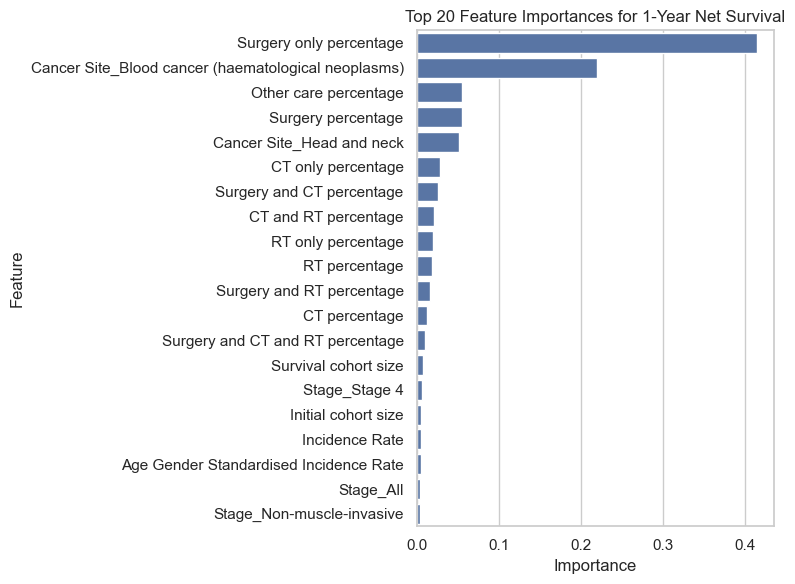

In [62]:
# Fit best model on full data for 12m survival to extract feature importances
best_pipe.fit(X, y_12)

# Get feature names after preprocessing
onehot_cols = list(
    best_pipe.named_steps["preprocess"]
    .named_transformers_["cat"]
    .named_steps["onehot"]
    .get_feature_names_out(categorical_features)
)

feature_names = onehot_cols + numeric_feature_cols

if best_model_name == "Random Forest":
    importances = best_pipe.named_steps["model"].feature_importances_
    feat_imp = (
        pd.DataFrame({"feature": feature_names, "importance": importances})
        .sort_values("importance", ascending=False)
        .head(20)
    )
    plt.figure(figsize=(8, 6))
    sns.barplot(data=feat_imp, x="importance", y="feature")
    plt.title("Top 20 Feature Importances for 1-Year Net Survival")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()
else:
    print("For linear models, inspect coefficients instead.")


## 9. Conclusions

**Summary of findings**

- The best-performing model for **1-year net survival (12m)** was:  
  - `Random Forest` with R² ≈ `0.952` on the test set.
- For **5-year net survival (60m)**, the same model achieved R² ≈ `0.947`.

**Key predictors**

Based on feature importances and exploratory analysis:

- **Stage** (e.g., Stage 1 vs Stage 4) is a major determinant of both 1- and 5-year survival.
- **Cancer Site / Tumour Type** substantially affects survival (e.g., blood cancers vs solid tumours).
- **Treatment patterns** (Surgery only, CT/RT combinations) and **Survival cohort size** also influence observed survival rates.
- **Incidence Rate** and standardized incidence rates are associated with differences in survival, possibly reflecting underlying risk factors and screening.

**Model performance and limitations**

- The models explain a substantial portion of the variance in 1-year survival, with somewhat lower performance on 5-year survival (as expected due to more long-term variability).
- The analysis is based on **aggregated cohort-level data**, not individual patients, which limits conclusions at the individual level.
- Treatment variables are summarized percentages and may not capture sequencing, intensity, or comorbidities.

**Implications**

- Earlier stage at diagnosis and certain treatment combinations are strongly associated with higher survival,
  reinforcing the importance of early detection and access to appropriate therapy.
- Such models can help highlight high-risk cancer groups and regions where additional resources or screening
  programs could be most impactful.
